In [1]:
import wandb

api = wandb.Api()
entity, project = "sayakpaul", "keras-xla-benchmarks"  
runs = api.runs(entity + "/" + project) 
print(f"Total runs: {len(runs)}")

Total runs: 588


In [2]:
import pandas as pd

resolutions = []
accelerators = []

model_families = []
model_variants = []
xla_status = []

flops = []
params = []
throughputs = []

for run in runs:
    run_config = run.config
    run_summary = run.summary._json_dict

    model_families.append(run_config["family"])
    model_variants.append(run_config["variant"])
    resolutions.append(run_config["resolution"])
    xla_status.append(run_config["xla"])

    accelerator_name = run.name.split("@")[-1].split("-")[1]
    accelerators.append(accelerator_name)

    flops.append(run_summary["FLOPs (giga)"])
    params.append(run_summary["Num parameters (million)"])
    throughputs.append(run_summary["Throughput (samples/sec)"])

viz_df = pd.DataFrame(
    {
        "model_family": model_families,
        "model_variant": model_variants,
        "resolution": resolutions,
        "xla": xla_status,
        "accelerator": accelerators,
        "flop (giga)": flops,
        "params (million)": params,
        "throughput (samples/sec)": throughputs,
    }
)
viz_df.head()

,model_family,model_variant,resolution,xla,accelerator,flop (giga),params (million),throughput (samples/sec)
0,MLP-Mixer,mixer_l16,224,True,a100,44.60,208.20,516.60
1,MLP-Mixer,mixer_l16,224,False,a100,44.60,208.20,540.72
2,MLP-Mixer,mixer_b32,224,True,a100,3.24,60.29,1539.56
3,MLP-Mixer,mixer_b32,224,False,a100,3.24,60.29,879.10
4,MLP-Mixer,mixer_b16,224,True,a100,12.62,59.88,1206.30


In [4]:
viz_df.to_csv("keras_xla_benchmarks.csv", index=False)

In [3]:
# For the CNN model families, which one is the best?
# What about model families?
grouped = viz_df.groupby(["resolution", "model_family", "accelerator"])[
    "throughput (samples/sec)"
].idxmax()
result = viz_df.loc[grouped, viz_df.columns]
result

,model_family,model_variant,resolution,xla,accelerator,flop (giga),params (million),throughput (samples/sec)
556,ConvNeXt,convnext_tiny,224,True,a100,4.37,28.59,1167.16
384,ConvNeXt,convnext_tiny,224,True,t4,4.37,28.59,147.22
389,ConvNeXt,convnext_tiny,224,True,v100,4.37,28.59,711.74
36,DeiT,deit_small_patch16_224,224,True,a100,4.62,22.05,1163.27
108,DeiT,deit_tiny_distilled_patch16_224,224,True,t4,1.27,5.91,738.04
...,...,...,...,...,...,...,...,...
158,RetinaNet,retinanet_resnet50_pascalvoc,640,True,t4,72.82,35.60,30.87
166,RetinaNet,retinanet_resnet50_pascalvoc,640,True,v100,72.82,35.60,92.71
154,YOLOV8,yolo_v8_m_pascalvoc,640,True,a100,39.42,25.90,417.84
162,YOLOV8,yolo_v8_m_pascalvoc,640,True,t4,39.42,25.90,54.61


In [4]:
result[result["accelerator"] == "a100"].sort_values(
    by=["throughput (samples/sec)"], ascending=False
)

,model_family,model_variant,resolution,xla,accelerator,flop (giga),params (million),throughput (samples/sec)
514,MobileNet_V1,mobilenet_v1,224,True,a100,0.57,4.25,2608.05
498,RegNet_X,regnetx_016,224,True,a100,0.10,2.71,1977.21
512,MobileNet_V2,mobilenet_v2,224,True,a100,0.30,3.54,1724.67
2,MLP-Mixer,mixer_b32,224,True,a100,3.24,60.29,1539.56
510,VGG,vgg16,224,True,a100,15.48,138.36,1514.04
482,RegNet_Y,regnety_002,224,True,a100,0.10,3.18,1261.35
556,ConvNeXt,convnext_tiny,224,True,a100,4.37,28.59,1167.16
36,DeiT,deit_small_patch16_224,224,True,a100,4.62,22.05,1163.27
79,ViT,vit_s16,224,False,a100,4.25,22.05,1055.06
18,Swin,swin_tiny_patch4_window7_224,224,True,a100,4.53,28.29,1022.69


In [5]:
result.query("resolution == 224 and accelerator == 'a100'").sort_values(
    by=["throughput (samples/sec)"], ascending=False
)

,model_family,model_variant,resolution,xla,accelerator,flop (giga),params (million),throughput (samples/sec)
514,MobileNet_V1,mobilenet_v1,224,True,a100,0.57,4.25,2608.05
498,RegNet_X,regnetx_016,224,True,a100,0.10,2.71,1977.21
512,MobileNet_V2,mobilenet_v2,224,True,a100,0.30,3.54,1724.67
2,MLP-Mixer,mixer_b32,224,True,a100,3.24,60.29,1539.56
510,VGG,vgg16,224,True,a100,15.48,138.36,1514.04
482,RegNet_Y,regnety_002,224,True,a100,0.10,3.18,1261.35
556,ConvNeXt,convnext_tiny,224,True,a100,4.37,28.59,1167.16
36,DeiT,deit_small_patch16_224,224,True,a100,4.62,22.05,1163.27
79,ViT,vit_s16,224,False,a100,4.25,22.05,1055.06
18,Swin,swin_tiny_patch4_window7_224,224,True,a100,4.53,28.29,1022.69


In [6]:
# Adapted from
# https://github.com/nlp-with-transformers/notebooks/blob/main/08_model-compression.ipynb

import matplotlib.pyplot as plt


def plot_metrics(df, savefig=False):
    for model_variant in df["model_variant"]:
        filtered = df.query(f"model_variant == '{model_variant}'")
        plt.scatter(
            filtered["flop (giga)"],
            filtered["throughput (samples/sec)"],
            alpha=0.5,
            s=filtered["params (million)"] * 5,
            label=model_variant,
            marker="o",
        )

    legend = plt.legend(bbox_to_anchor=(1, 1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylabel("Throughput (samples/sec)", fontsize=14)
    plt.xlabel("FLOPS (giga)", fontsize=14)

    accelerator_name = df["accelerator"].unique()[0]
    resolution = df["resolution"].unique()[0]
    xla_status = df["xla"].unique()[0]
    plt.title(
        f"Accelerator: {accelerator_name}, Resolution: {resolution}, XLA: {xla_status}",
        fontsize=14,
    )
    if not savefig:
        plt.show()
    else:
        plot_name = f"{accelerator_name}_{resolution}_{xla_status}.png"
        plt.savefig(plot_name, dpi=300, bbox_inches="tight")

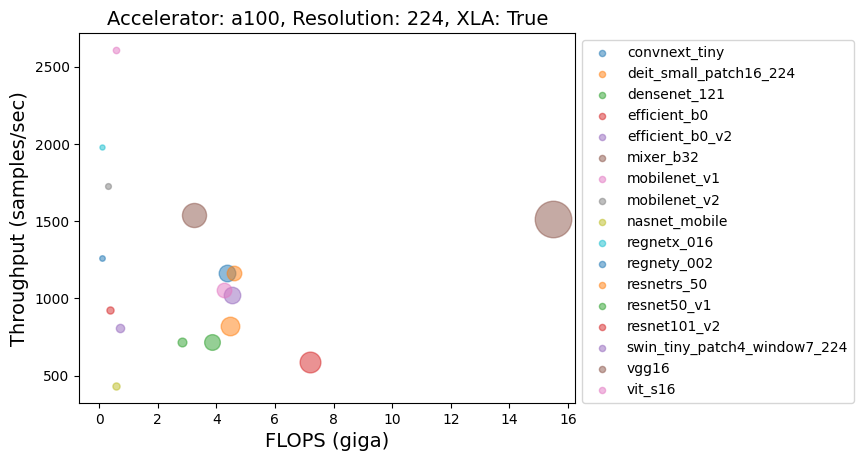

In [7]:
df_224_a100 = result.query("resolution == 224 and accelerator == 'a100'")

plot_metrics(df_224_a100)

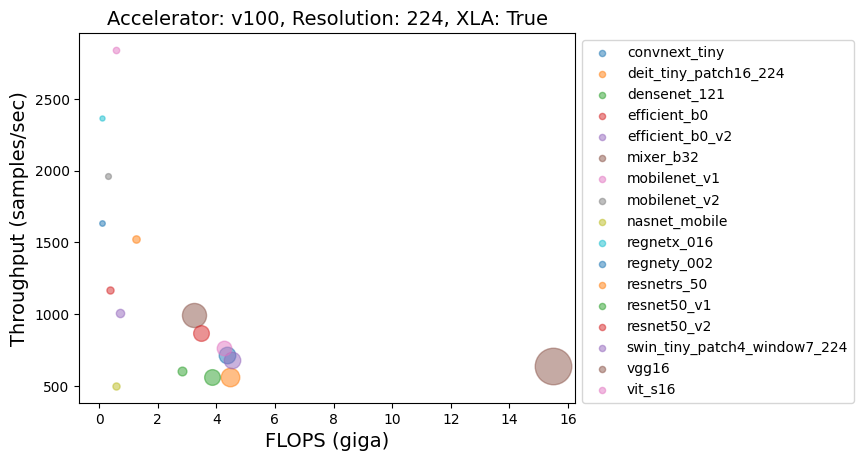

In [8]:
df_224_v100 = result.query("resolution == 224 and accelerator == 'v100'")

plot_metrics(df_224_v100)

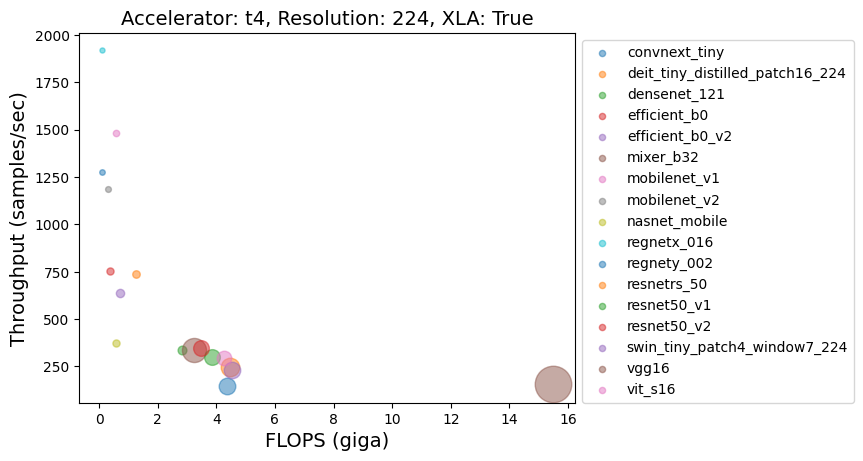

In [9]:
df_224_t4 = result.query("resolution == 224 and accelerator == 't4'")

plot_metrics(df_224_t4)